In [551]:
# imports
import numpy as np
import scipy.io as sio
from skimage.util import montage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle

np.random.seed(2)

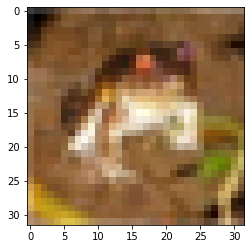

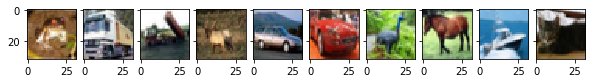

In [454]:
#Loading and exploring data from mat-file 
matdata  = sio.loadmat('Dataset/cifar-10-batches-mat/data_batch_1.mat')
A = matdata['data'] #size 10000 x 3072. row of A.data corresponds to an image of size 32 x 32 x 3 that has been attened into a row vector.
A = np.array(A)
im = np.transpose(np.reshape(A[0, :],(3, 32,32)), (1,2,0))
im = (im - im.min()) / (im.max() - im.min())
plt.imshow(im)

plot_pictures(A[0:10,:])

In [455]:
'''Given from template.
Translated form Matlab to Python by someone in the course'''

def ComputeGradsNum(X, Y, P, W, b, lam, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));

    c = ComputeCost(X, Y, W, b, lam);
    
    for i in range(len(b)):
        print(i, "out of ", len(b))
        b_try = np.array(b)
        b_try[i] += h
        #print(b_try)
        c2 = ComputeCost(X, Y, W, b_try, lam)
        #print(c)
        #print(c2)
        #print(c2-c)
        grad_b[i] = (c2-c) / h

    for i in range(W.shape[0]):
        print(i, "out of ", W.shape[0])
        for j in range(W.shape[1]):
            W_try = W
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lam)
            grad_W[i,j] = (c2-c) / h

    return grad_W, grad_b 

def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));
    
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = ComputeCost(X, Y, W, b_try, lamda)

        b_try = b
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)

        grad_b[i] =  (c2-c1) / (2*h)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = W
            W_try[i,j] -= h
            c1 = ComputeCost(X, Y, W_try, b, lamda)

            W_try = W
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)

            grad_W[i,j] =  (c2-c1) / (2*h)

    return [grad_W, grad_b]

In [590]:
# Exercise 1: Trainin a multi-linear classifier
K=10

#functions
# 1. LoadBatch reads reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files
def LoadBatch(filename):
    matdata  = sio.loadmat(filename)
    X = np.matrix(matdata['data']).T.astype(float)
    y = np.array(matdata['labels'])
    Y = ((np.arange(K) == y[:,:]).astype(int)).T #??
    #print(X.shape, Y.shape)
    return X,Y,y

# normalize matrix (https://datascience.stackexchange.com/questions/39142/normalize-matrix-in-python-numpy)
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

# 4. EvaluateClassifier function that evaluates the network function
'''
X: each column of X corresponds to an image and it has size dxn.
W, b: W and b are the parameters of the network.
P: each column of P contains the probability for each label for the image 
in the corresponding column of X. P has size Kxn.'''

def EvaluateClassifier(X,W,b):
    s = W*X+b
    p = softmax(s)
    return p

def softmax(scores):
    return np.exp(scores)/np.sum(np.exp(scores), axis=0)


# 5. Compute cost function
'''
X: each column of X corresponds to an image and X has size dxn.
Y: each column of Y (Kxn) is the one-hot ground truth label for the 
corresponding column of X or Y is the (1xn) vector of ground truth labels.
J: J is a scalar corresponding to the sum of the loss of the network's
predictions for the images in X relative to the ground truth labels and
the regularization term on W.

def ComputeCost(X, Y, W, b, lam):
    #print(lam * np.sum(np.square(W)))
    #print(np.sum(ComputeLossCrossEntropy(X,Y,W,b), axis=1))
    J = 1/X[1].size * (np.sum(ComputeLossCrossEntropy(X,Y,W,b), axis=1) + lam * np.sum(np.square(W)))
    return J 
    
def ComputeLossCrossEntropy(X,Y,W,b):
    p= EvaluateClassifier(X,W,b)
    #print(p)
    return -1*np.log(np.dot(Y.T,p))
        
def ComputeCost(X, Y, W, b, lam):
    N = X.shape[1]
    p = EvaluateClassifier(X,W,b)
    J = -np.sum(Y*np.log(p))/N + lam * np.sum(np.square(W))
    return J 
'''

def ComputeCost(X, Y, W, b, lam):
    Y = np.reshape(Y, (K, -1))
    N = X.shape[1]
    J = 1/N * (np.sum(LossCrossEntropy(X,Y,W,b)) + lam * np.sum(np.square(W)))
    return J 
    
def LossCrossEntropy(X,Y,W,b):
    p = EvaluateClassifier(X,W,b)
    return - np.log(np.multiply(Y, p).sum(axis=0))


# 6. computes the accuracy of the network's predictions on a set of data.
'''
X: each column of X corresponds to an image and X has size dxn.
y: y is the vector of ground truth labels of length n.
acc: acc is a scalar value containing the accuracy.
'''
def ComputeAccuracy(X, y, W, b):
    p = EvaluateClassifier(X,W,b)
    pred = np.argmax(p, axis=0)
    #print(pred.T.shape)
    #print(y.shape)
    same = np.count_nonzero(pred.T == y)
    #print(same)
    acc = same / X[1].size
    return acc


# 7. function that evaluates, for a mini-batch, the gradients of the cost function w.r.t. W and b
'''
X: each column of X corresponds to an image and it has size dxn.
Y: each column of Y (Kxn) is the one-hot ground truth label for the corresponding column of X.
P: each column of P contains the probability for each label for the image in the corresponding column of X. P has size Kxn.
grad_W: grad_W is the gradient matrix of the cost J relative to W and has size Kxd.
def ComputeGradients(X, Y,P, W, lam):
    #P = EvaluateClassifier(X, W,b)
    g_batch = -(Y-P)
    ones =  np.full((X[1].size,1), 1)
    grad_W = 1/X[1].size * g_batch * X.T + 2*lam*W
    grad_b = 1/X[1].size * g_batch * ones
    return grad_W, grad_b    
'''

def ComputeGradients(X, Y, W, lam):
    #P = EvaluateClassifier(X, W,b)
    Y = np.reshape(Y, (K, -1))
    N =X[1].size 
    P = EvaluateClassifier(X,W,b)
    g_batch = -(Y-P)
    ones =  np.full((X[1].size,1), 1)
    grad_W = 1/N * g_batch * X.T + 2*lam*W
    grad_b = 1/N* g_batch * ones
    return grad_W, grad_b

def ComputeRelativeError(ga ,gn ,eps):
    #print(np.absolute(np.subtract(ga, gn)))
    #print(np.maximum( np.full(ga.shape, eps), np.add(np.absolute(ga),np.absolute(gn))))
    return np.absolute(np.subtract(ga, gn)) /  np.maximum( np.full(ga.shape, eps), np.add(np.absolute(ga),np.absolute(gn)))

In [591]:
# 8. Mini-batch gradient descent algorithm
'''
n_batch: the size of the mini-batches -> number of images in mini-batch
eta: learning rate
n_epochs: number of runs through the whole training set.'''

def GenerateMiniBatches(n_batch, X, Y, permute=True):
    n = X[1].size 
    X_batches = []
    Y_batches = []
    if permute:
        X, Y = shuffle(X.T, Y.T)
        print(X.shape, Y.shape)
        X = X.T
        Y = Y.T
    for j in range(int(n/n_batch)):
        j_start = j*n_batch 
        j_end = (j+1)*n_batch 
        X_batch = X[:, j_start:j_end]
        Y_batch = Y[:, j_start:j_end]
        X_batches.append(X_batch)
        Y_batches.append(Y_batch)
        
    return X_batches, Y_batches
 
# 8. Mini-batch functions
'''
X: all the training images
Y: labels for the training images
W,b: initial values for the network's parameters
lam: regularization factor in the cost function
GDparams: an object containing the parameter values n_batch, eta and n_epochs
'''


def MiniBatchGD(X, Y,y, W, b, n_batch=100, eta=0.001,n_epochs=20, lam=0, permute=True):
    costs_train = []
    accs_train = []
    costs_validate = []
    accs_validate  = []
    X_batches, Y_batches = GenerateMiniBatches(n_batch, X_train, Y_train)
    #print(X_batches.shape, Y_batches.shape )
    for epoch in range(n_epochs): #iterate over epochs
        print("epoch ",epoch)
        # iterate over mini-batches
        for idx, X_batch in enumerate(X_batches, start=0):
            Y_batch = Y_batches[idx]
            # compute gradients for batch
            grad_W_ana, grad_b_ana = ComputeGradients(X_batch, Y_batch, W, lam)

            # adjust W,b by eta
            W -= eta*grad_W_ana
            b -= eta*grad_b_ana

        # compute cost -> print and save it            
        cost_train = ComputeCost(X, Y, W, b, lam)
        costs_train.append(cost_train)
        print("cost_train: ",cost_train)
        # for validation
        cost_validate = ComputeCost(X_validate, Y_validate, W, b, lam)
        costs_validate.append(cost_validate)
        print("cost_validate: ",cost_validate)
            
        # compute acc -> print and save it
        acc_train = ComputeAccuracy(X, y, W, b)
        accs_train.append(acc_train)
        print("accuracy_train: ",acc_train)
        #for validation
        
        acc_validate = ComputeAccuracy(X_validate, y_validate, W, b)
        accs_validate.append(acc_validate)
        print("accuracy_validate: ",acc_validate)

    return costs_train, accs_train, costs_validate, accs_validate

In [592]:
# plotting 

# Pictures 1x10
def plot_pictures(trained_Weight):
    s_im =[]
    for label in range(trained_Weight.shape[0]):
        im =  np.transpose(np.reshape(trained_Weight[label, :], (3, 32,32)), (1,2,0))
        im = (im - im.min()) / (im.max() - im.min())
        #np.transpose( im, (1, 0, 2) )
        s_im.append(im)

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 10),  # creates 1x10 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, s_im):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()
    

# graphs



In [593]:
# 1. Read in and store the training, validation and test data.
(X_train,Y_train,y_train)= LoadBatch('Dataset/cifar-10-batches-mat/data_batch_1.mat')
(X_validate,Y_validate,y_validate)= LoadBatch('Dataset/cifar-10-batches-mat/data_batch_2.mat')
(X_test,Y_test,y_test)= LoadBatch('Dataset/cifar-10-batches-mat/test_batch.mat')

# 2. Pre-process
#mean_X = X_train.mean(axis=1)
#std_X = X_train.std(axis=1)

X_train= scale(X_train, -1,1)
X_validate= scale(X_validate, -1,1)
X_test= scale(X_test, -1,1)

# 3. Initialize parameters W and b
W = np.random.normal(0.0, 0.1, (K,X_train.shape[0])) 
b = np.random.normal(0.0, 0.1, (K,1)) 

#4. Evaluate classifiers
P = EvaluateClassifier(X_train, W,b)

#5. Compute cost 
J = ComputeCost(X_train, Y_train, W, b, 0)

#6. compute accuracy
acc = ComputeAccuracy(X_train, y_train, W, b)
#print(acc)

In [594]:
#7 gradients
#grad_W_ana, grad_b_ana = ComputeGradients(X_train[:, 1], Y_train[:, 1],P, W, 0)
#grad_W_ana, grad_b_ana = ComputeGradients(X_train[0:20, 1], Y_train[0:20, 1], W[:, 0:20], 0)

# numerical gradients with reduced dimensionality and lambda = 0
#grad_W_num, grad_b_num = ComputeGradsNum(X_train[:, 1], Y_train[:, 1], P, W, b, 0, 1e-6)
#grad_W_num, grad_b_num = ComputeGradsNum(X_train[0:20, 1], Y_train[0:20, 1], P, W[:, 0:20], b, 0, 1e-6)

# slow but precise computation
#grad_W_num, grad_b_num = ComputeGradsNumSlow(X_train[:, 1], Y_train[:, 1], P, W, b, 0, 1e-6)
#grad_W_num, grad_b_num = ComputeGradsNumSlow(X_train[0:20, 1], Y_train[0:20, 1], P, W[:, 0:20], b, 0, 1e-6)

#print(grad_b_num ,grad_b_ana)
# Compute the relative error and check if it is "small"
#ComputeRelativeError(grad_b_num ,grad_b_ana ,1e-6)

In [ ]:
#X_batches, Y_batches = GenerateMiniBatches(n_batch, X_train, Y_train, permute=True)
#X_batches[1].shape

costs_train, accs_train, costs_validate, accs_validate = MiniBatchGD(X_train, Y_train, y_train, W, b, 100, 0.001, 40, 1, True)



(10000, 3072) (10000, 10)
epoch  0
cost_train:  3.410610303088507
cost_validate:  3.4465308080318553
accuracy_train:  0.133
accuracy_validate:  0.1297
epoch  1
cost_train:  2.71966408163782
cost_validate:  2.751974204169901
accuracy_train:  0.1677
accuracy_validate:  0.1669
epoch  2
cost_train:  2.3835649345772985
cost_validate:  2.4165497634244475
accuracy_train:  0.1999
accuracy_validate:  0.1989
epoch  3
cost_train:  2.1980155718098286
cost_validate:  2.2314669406683834
accuracy_train:  0.2285
accuracy_validate:  0.2243
epoch  4


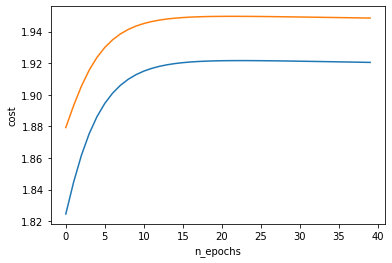

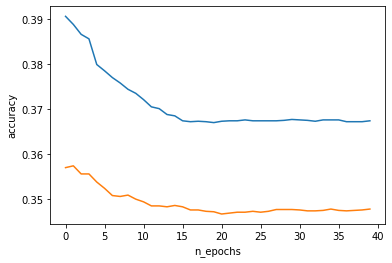

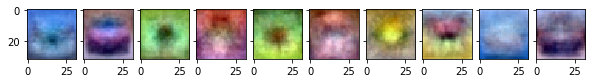

In [588]:
# plotting costs
plt.plot(costs_train, label = "costs_train")
plt.plot(costs_validate, label = "cost_validate")
plt.xlabel('n_epochs')
plt.ylabel('cost')
plt.show()

# plotting accuracy
plt.plot(accs_train, label = "accs_train")
plt.plot(accs_validate, label = "accs_validate")
plt.xlabel('n_epochs')
plt.ylabel('accuracy')
plt.show()

# plotting pictures from W
plot_pictures(W)